# Chapter 8 Segmentation and Object Detection

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import os
from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

import time

sns.set_theme(style="darkgrid", palette="pastel")
sns.set_context("notebook")

from utils import train_model

We will be segmenting cell nuclei using a dataset from the [2018 Data Science Bowl on Kaggle](https://www.kaggle.com/c/data-science-bowl-2018).  We've preprocessed the data so that the individual masks for each cell nucleus are combined into a single mask for all the nuclei in the image.  The images are also resized to 256x256 for simplicity.  The images and masks are stored in the data folder.  You can download a zipped copy of the dataset from Canvas for exploration.

## Dataset

The next cell shows our custom Dataset which loads an image and its mask from the specified root directory.  It also applies whatever torchvision transforms you specify to the image and its mask.  Take care if applying transforms that are random since they may not process the image and the mask the same way!

In [2]:
class DSB2018(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'masks' subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        
        self.image_names = [f for f in os.listdir(self.images_dir) if os.path.isfile(os.path.join(self.images_dir, f))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, 'mask_' + self.image_names[idx])

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")  # Convert to grayscale to handle masks

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dsb_data = DSB2018(root_dir='./data', transform=transform)

# Example of loading an image and its mask
image, mask = dsb_data[0]  # Get the first sample

print(image.shape, mask.shape)  # Example of how to check the sizes


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


## Plot a sample image and mask

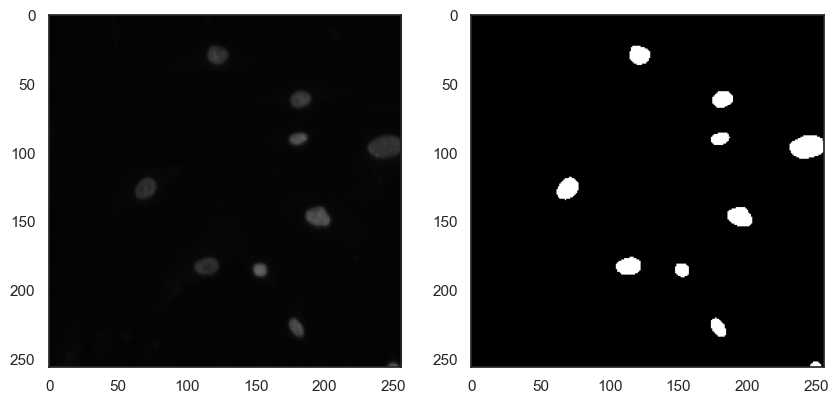

In [3]:
sns.set_theme(style='white')

plt.figure(figsize=(10,8))
#Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1,2,0).numpy());
#Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray');

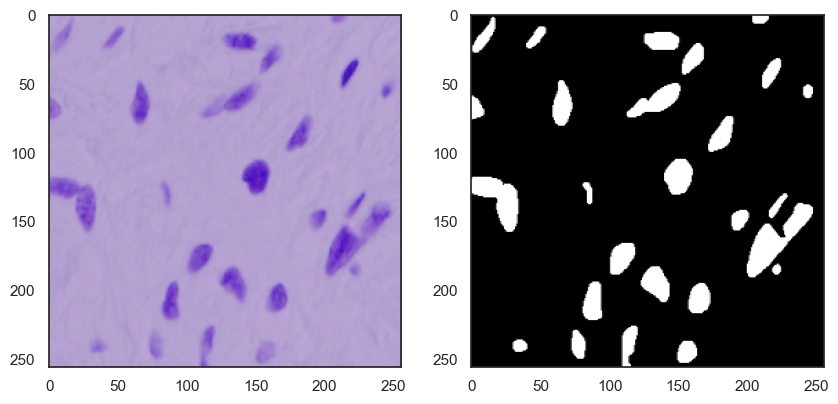

In [13]:
#Lets plot a second image that is in color
index = 10
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[index][0].permute(1,2,0).numpy())
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[index][1].numpy()[0,:], cmap='gray');

In [14]:
train_split, test_split = torch.utils.data.random_split(dsb_data, [500, len(dsb_data)-500])
train_seg_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_seg_loader = DataLoader(test_split,  batch_size=16)

In [15]:
C = 3 #How many channels are in the input? 
n_filters = 32 #Smallest value of filters you should usually consider. If we wanted to try and optimize the architecture we could use Optuna to pick a better number of filters. 
loss_func = nn.BCEWithLogitsLoss()#BCE loss implicitly assumes a binary problem

In [22]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
#Specifying a model for image segmentation
segmentation_model = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    *[cnnLayer(n_filters, n_filters) for _ in range(5)], #Create 5 more hidden layers
    #Make a prediction for _every_ location. Notice we use 1 channel out, since we have a binary problem and are using BCEWithLogitsLoss as our loss function. 
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (1, W, H)
)
#train the segmentation model
seg_results = train_model(segmentation_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )              

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.114957  0.135592 10.104999 0.001
    12    0.123299  0.097622  9.965034 0.001
    13    0.122811  0.110825 10.065081 0.001
    14    0.112157  0.225497 10.023625 0.001
    15    0.113645  0.128046 10.054119 0.001


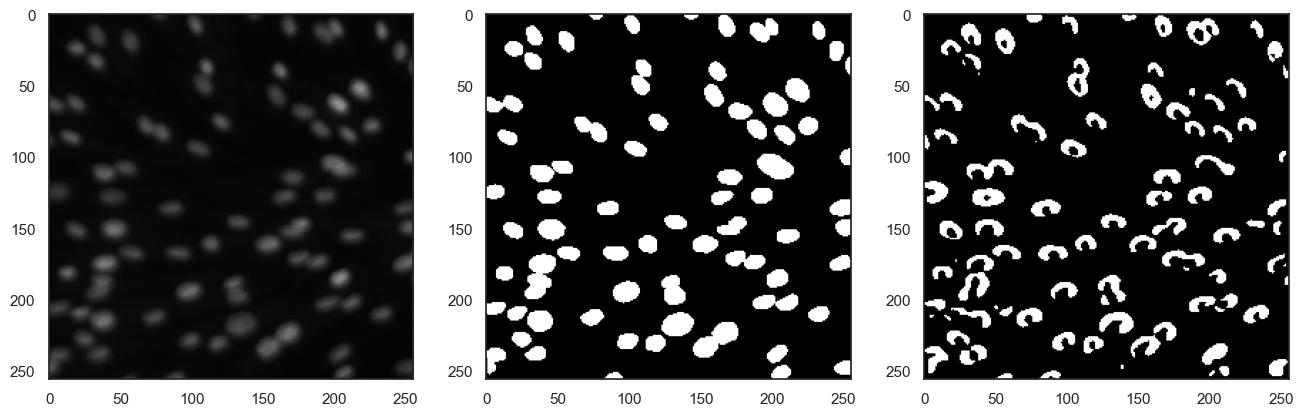

In [41]:
#plot an image, mask, and predicted mask

index = 0 # Change this to look at other entries from the dataset.

def plot_three(model, index):

    with torch.no_grad():# If we aren't training, so no gradients please!
        #push a test datapoint through the model. Remember the raw outputs are called the logits
        logits = model(test_split[index][0].unsqueeze(0))[0].cpu()
        #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
        pred = torch.sigmoid(logits) >= 0.5
    
    #Plot the input, ground truth, and prediction
    plt.figure(figsize=(16,10))
    plt.subplot(1, 3, 1)
    plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray') #First plot the original input to the network
    plt.subplot(1, 3, 2)
    plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
    plt.subplot(1, 3, 3) 
    plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

plot_three(segmentation_model, index)

In [24]:
segmentation_model2 = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d(2), #Shrinks the height and width by 2
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    #Double the height and width, countering the effect of the single MaxPool2d before
    nn.ConvTranspose2d(2*n_filters, n_filters, (3,3), padding=1, output_padding=1, stride=2),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    #Back to normal convolutions
    cnnLayer(n_filters, n_filters),
    #Prediction for _every_ location
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

#train the segmentation model
seg_results2 = train_model(segmentation_model2, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.111841  0.121922  9.843189 0.001
    12    0.106017  0.084113 10.075554 0.001
    13    0.107288  0.108590 10.249962 0.001
    14    0.102185  0.098956 10.063203 0.001
    15    0.103956  0.083497 10.119377 0.001


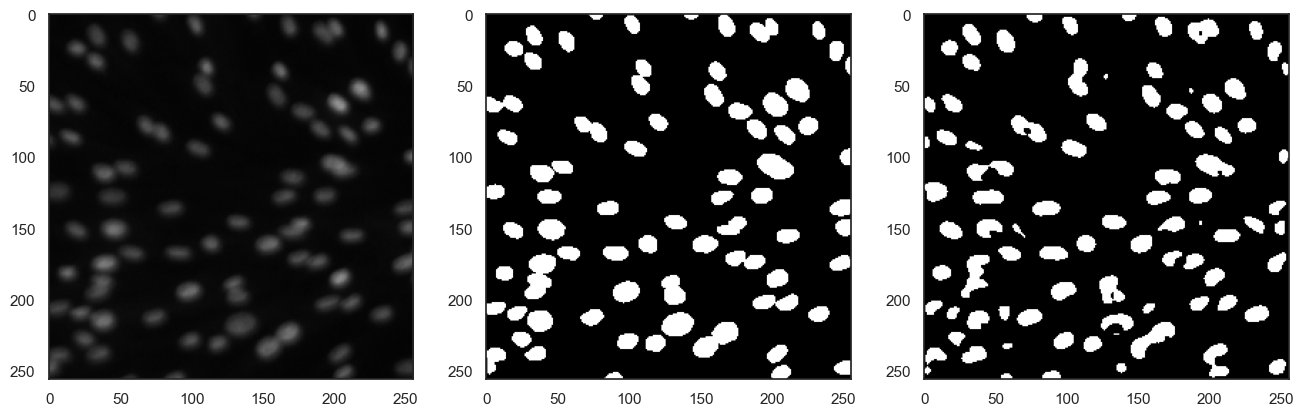

In [42]:
#plot an image, mask, and predicted mask

index = 0 # Change this to look at other entries from the dataset.
plot_three(segmentation_model2, index)

<Axes: xlabel='Epoch', ylabel='val_loss'>

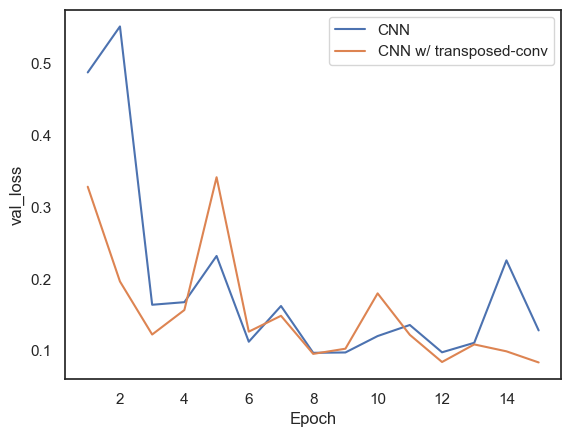

In [37]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results, label='CNN')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results2, label='CNN w/ transposed-conv')

In [38]:
class UNetBlock2d(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this 
    def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
        """ 
        in_channels: the number of channels in the input to this block
        mid_channels: the number of channels to have as the output for each convolutional filter
        out_channels: if not `None`, ends the network with a 1x1 convolution to convert the number of output channels to a specific number. 
        layers: how many blocks of hidden layers to create on both the input and output side of a U-Net block
        sub_network: the network to apply after shrinking the input by a factor of 2 using max pooling. The number of output channels should be equal to `mid_channels`
        filter_size: how large the convolutional filters should be
        """
        super().__init__()
        
        #Start preparing the layers used to process the input
        in_layers = [cnnLayer(in_channels, mid_channels, filter_size)]
        
        #If we have a sub-network, we will double the number of inputs to the output. So lets figure that out now
        if sub_network is None:
            inputs_to_outputs = 1
        else:
            inputs_to_outputs = 2

        #Preparing the layers used to make the final output, which has extra input channels from any sub-network
        out_layers = [ cnnLayer(mid_channels*inputs_to_outputs, mid_channels, filter_size)]
        
        #Make the additional hidden layers used for the input and output
        for _ in range(layers-1):
            in_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
            out_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
        #Use 1x1 Convolutions to ensure a specific output size
        if out_channels is not None:
            out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    
        #define our three total sub-networks:
        #1) in_model performs the intial rounds of convolution
        self.in_model = nn.Sequential(*in_layers)
        #2) our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
        if sub_network is not None:
            self.bottleneck = nn.Sequential(
                nn.MaxPool2d(2), #Shrink
                sub_network, #process the smaller resolution
                #expand back up
                nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, output_padding=1, stride=2)
            )
        else:
            self.bottleneck = None
        #3) the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
        self.out_model = nn.Sequential(*out_layers)
        
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #compute the convolutions at the current scale
        full_scale_result = self.in_model(x) #(B, C, W, H)
        #check if we have a bottleneck to apply
        if self.bottleneck is not None:
            #(B, C, W, H) shape because bottleneck does both the pooling & expansion
            bottle_result = self.bottleneck(full_scale_result)
            #Now shape (B, 2*C, W, H)
            full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
        #compute the output on the concatenated (or not!) result
        return self.out_model(full_scale_result)
#Caption: A class implementing a “Block” of the U-Net approach. Each block needs to know how many channels are coming in and out of the block. The block has three components. 1) the input network, what processes the raw input coming into this block. 2) the bottleneck, which is what the block runs after shrinking the current results down by a factor of 2, and then expands the result back up to the original size. 3) the output network, which is run on the results from the prior two sub-networks concatenated together. 

In [39]:
unet_model = nn.Sequential(
    UNetBlock2d(3, 32, layers=2, sub_network=
        UNetBlock2d(32, 64, out_channels=32, layers=2, sub_network=
            UNetBlock2d(64, 128, out_channels=64, layers=2)
        ),
    ),
    #Prediction for _every_ location
    nn.Conv2d(32, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

#train the segmentation model
unet_results = train_model(unet_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.094245  0.067044 18.611371 0.001
    12    0.081594  0.072253 18.713509 0.001
    13    0.082099  0.067051 18.710100 0.001
    14    0.080964  0.062526 18.935718 0.001
    15    0.079565  0.059701 18.922702 0.001


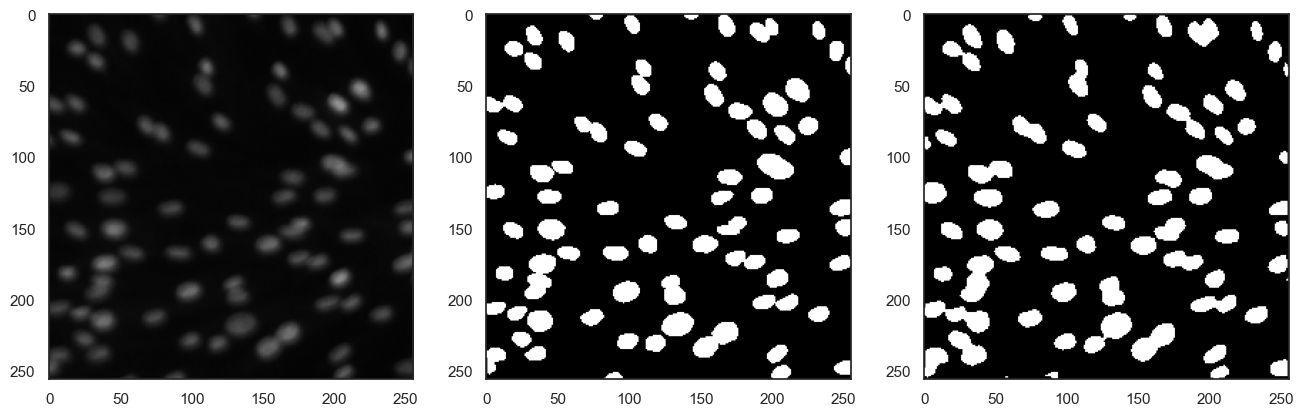

In [45]:
index = 0 # Same example from before
plot_three(unet_model,index)

<Axes: xlabel='Epoch', ylabel='val_loss'>

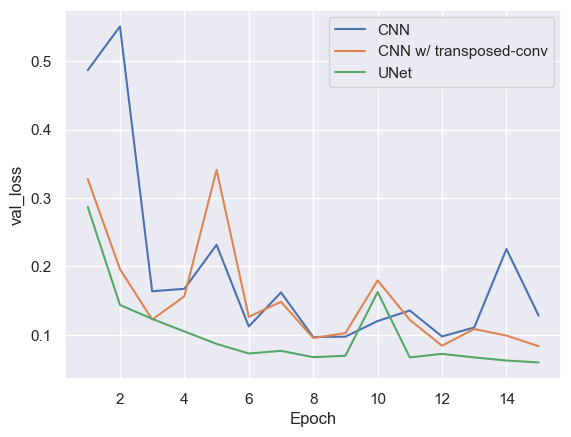

In [46]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results, label='CNN')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results2, label='CNN w/ transposed-conv')
sns.lineplot(x='Epoch', y='val_loss', data=unet_results, label='UNet')

### Some U-net variations:

These networks are copied from one the Kaggle competition notebooks - https://www.kaggle.com/code/abhiswain/unet-pytorchlightning

In [47]:
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class DoubleConvSame(nn.Module):
    def __init__(self, c_in, c_out):
        super(DoubleConvSame, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet_2(nn.Module):
    def __init__(self, c_in, c_out):
        super(UNet_2, self).__init__()

        self.conv1 = DoubleConvSame(c_in=c_in, c_out=64)
        self.conv2 = DoubleConvSame(c_in=64, c_out=128)
        self.conv3 = DoubleConvSame(c_in=128, c_out=256)
        self.conv4 = DoubleConvSame(c_in=256, c_out=512)
        self.conv5 = DoubleConvSame(c_in=512, c_out=1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )
        self.up3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2
        )
        self.up4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2
        )

        self.up_conv1 = DoubleConvSame(c_in=1024, c_out=512)
        self.up_conv2 = DoubleConvSame(c_in=512, c_out=256)
        self.up_conv3 = DoubleConvSame(c_in=256, c_out=128)
        self.up_conv4 = DoubleConvSame(c_in=128, c_out=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2 = self.conv2(p1)
        p2 = self.pool(c2)

        c3 = self.conv3(p2)
        p3 = self.pool(c3)

        c4 = self.conv4(p3)
        p4 = self.pool(c4)
        """BOTTLE-NECK"""

        c5 = self.conv5(p4)
        """DECODER"""

        u1 = self.up1(c5)
        cat1 = torch.cat([u1, c4], dim=1)
        uc1 = self.up_conv1(cat1)

        u2 = self.up2(uc1)
        cat2 = torch.cat([u2, c3], dim=1)
        uc2 = self.up_conv2(cat2)

        u3 = self.up3(uc2)
        cat3 = torch.cat([u3, c2], dim=1)
        uc3 = self.up_conv3(cat3)

        u4 = self.up4(uc3)
        cat4 = torch.cat([u4, c1], dim=1)
        uc4 = self.up_conv4(cat4)

        outputs = self.conv_1x1(uc4)

        return outputs


class UNet_OG(nn.Module):
    def __init__(self, c_in, c_out):
        super(UNet_OG, self).__init__()

        self.conv1 = DoubleConv(c_in=c_in, c_out=64)
        self.conv2 = DoubleConv(c_in=64, c_out=128)
        self.conv3 = DoubleConv(c_in=128, c_out=256)
        self.conv4 = DoubleConv(c_in=256, c_out=512)
        self.conv5 = DoubleConv(c_in=512, c_out=1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )
        self.up3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2
        )
        self.up4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2
        )

        self.up_conv1 = DoubleConv(c_in=1024, c_out=512)
        self.up_conv2 = DoubleConv(c_in=512, c_out=256)
        self.up_conv3 = DoubleConv(c_in=256, c_out=128)
        self.up_conv4 = DoubleConv(c_in=128, c_out=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1)

    def crop_tensor(self, up_tensor, target_tensor):
        _, _, H, W = up_tensor.shape

        x = CenterCrop(size=(H, W))(target_tensor)

        return x

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2 = self.conv2(p1)
        p2 = self.pool(c2)

        c3 = self.conv3(p2)
        p3 = self.pool(c3)

        c4 = self.conv4(p3)
        p4 = self.pool(c4)
        """BOTTLE-NECK"""

        c5 = self.conv5(p4)
        """DECODER"""

        u1 = self.up1(c5)
        crop1 = self.crop_tensor(u1, c4)
        cat1 = torch.cat([u1, crop1], dim=1)
        uc1 = self.up_conv1(cat1)

        u2 = self.up2(uc1)
        crop2 = self.crop_tensor(u2, c3)
        cat2 = torch.cat([u2, crop2], dim=1)
        uc2 = self.up_conv2(cat2)

        u3 = self.up3(uc2)
        crop3 = self.crop_tensor(u3, c2)
        cat3 = torch.cat([u3, crop3], dim=1)
        uc3 = self.up_conv3(cat3)

        u4 = self.up4(uc3)
        crop4 = self.crop_tensor(u4, c1)
        cat4 = torch.cat([u4, crop4], dim=1)
        uc4 = self.up_conv4(cat4)

        outputs = self.conv_1x1(uc4)

        return outputs

class AttentionBlock(nn.Module):
    """
    Class for creating Attention module
    Takes in gating signal `g` and `x`
    """

    def __init__(self, g_chl, x_chl):
        super(AttentionBlock, self).__init__()

        inter_shape = x_chl // 4

        # Conv 1x1 with stride 2 for `x`
        self.conv_x = nn.Conv2d(
            in_channels=x_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=2,
        )

        # Conv 1x1 with stride 1 for `g` (gating signal)
        self.conv_g = nn.Conv2d(
            in_channels=g_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=1,
        )

        # Conv 1x1 for `psi` the output after `g` + `x`
        self.psi = nn.Conv2d(
            in_channels=2 * inter_shape,
            out_channels=1,
            kernel_size=1,
            stride=1,
        )

        # For upsampling the attention output to size of `x`
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, g, x):

        # perform the convs on `x` and `g`
        theta_x = self.conv_x(x)
        gate = self.conv_g(g)

        # `theta_x` + `gate`
        add = torch.cat([self.conv_x(x), self.conv_g(g)], axis=1)

        # ReLU on the add operation
        relu = torch.relu(add)

        # the 1x1 Conv
        psi = self.psi(relu)

        # Sigmoid the squash the outputs/attention weights
        sig = torch.sigmoid(psi)

        # Upsample to original size of `x` to perform multiplication
        upsample = self.upsample(sig)

        # return the attention weights!
        return upsample


class AttentionUNet(nn.Module):
    def __init__(self, c_in, c_out):
        super(AttentionUNet, self).__init__()

        self.conv1 = DoubleConvSame(c_in=c_in, c_out=64)
        self.conv2 = DoubleConvSame(c_in=64, c_out=128)
        self.conv3 = DoubleConvSame(c_in=128, c_out=256)
        self.conv4 = DoubleConvSame(c_in=256, c_out=512)
        self.conv5 = DoubleConvSame(c_in=512, c_out=1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.attn1 = AttentionBlock(1024, 512)
        self.attn2 = AttentionBlock(512, 256)
        self.attn3 = AttentionBlock(256, 128)
        self.attn4 = AttentionBlock(128, 64)

        self.up1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )
        self.up3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2
        )
        self.up4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2
        )

        self.up_conv1 = DoubleConvSame(c_in=1024, c_out=512)
        self.up_conv2 = DoubleConvSame(c_in=512, c_out=256)
        self.up_conv3 = DoubleConvSame(c_in=256, c_out=128)
        self.up_conv4 = DoubleConvSame(c_in=128, c_out=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2 = self.conv2(p1)
        p2 = self.pool(c2)

        c3 = self.conv3(p2)
        p3 = self.pool(c3)

        c4 = self.conv4(p3)
        p4 = self.pool(c4)

        """BOTTLE-NECK"""

        c5 = self.conv5(p4)

        """DECODER - WITH ATTENTION"""

        att1 = self.attn1(c5, c4)
        u1 = self.up1(c5)
        mult1 = torch.multiply(att1, u1)
        cat1 = torch.cat([mult1, c4], dim=1)
        uc1 = self.up_conv1(cat1)

        att2 = self.attn2(uc1, c3)
        u2 = self.up2(uc1)
        mult2 = torch.multiply(att2, u2)
        cat2 = torch.cat([mult2, c3], dim=1)
        uc2 = self.up_conv2(cat2)

        att3 = self.attn3(uc2, c2)
        u3 = self.up3(uc2)
        mult3 = torch.multiply(att3, u3)
        cat3 = torch.cat([mult3, c2], dim=1)
        uc3 = self.up_conv3(cat3)

        att4 = self.attn4(uc3, c1)
        u4 = self.up4(uc3)
        mult4 = torch.multiply(att4, u4)
        cat4 = torch.cat([mult4, c1], dim=1)
        uc4 = self.up_conv4(cat4)

        outputs = self.conv_1x1(uc4)

        return outputs

### Training and Evaluating Attention U-Net

In [48]:
attn_unet_model = AttentionUNet(3,1)

#train the segmentation model
attn_unet_results = train_model(attn_unet_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

Epoch 1/15, Training 81.25% complete lr = 1.000e-03


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [21]:
set_seed(42)

In [22]:
class Class2Detect(Dataset):
    """This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem. """

    def __init__(self, dataset, toSample=3, canvas_size=100):
        """
        dataset: the source dataset to sample items from as the "objects" to detect
        toSample: the maximum number of "objects" to put into any image
        canvas_size: the width and height of the images to place objects inside of. 
        """
        self.dataset = dataset
        self.toSample = toSample
        self.canvas_size = canvas_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        boxes = []
        labels = []
        
        final_size = self.canvas_size
        #First, create a larger image that will store all the "objects" to detect
        img_p = torch.zeros((final_size,final_size), dtype=torch.float32)
        #Now we are going to sample up to self.toSample objects to place into the image
        for _ in range(np.random.randint(1,self.toSample+1)):
            
            #Pick an object at random from the original dataset, and its label
            img, label = self.dataset[np.random.randint(0,len(self.dataset))]
            #Get the height and width of that image
            _, img_h, img_w = img.shape
            #Pick a random offset of the x and y axis, essentially placing the image at a random location
            offsets = np.random.randint(0,final_size-np.max(img.shape),size=(4))
            #Change the padding at the end to make sure we come out to a specific 100,100 shape
            offsets[1] = final_size - img.shape[1] - offsets[0]
            offsets[3] = final_size - img.shape[2] - offsets[2]
            
            with torch.no_grad():
                img_p = img_p + F.pad(img, tuple(offsets))
            #Lets craete the values for the "boxes"
            #all of these are in absolute pixel locations
            
            #x_min determined by the randomly selected offset
            xmin = offsets[0]
            #x_max is the offset plus the image's width
            xmax = offsets[0]+img_w
            #y min/max follows the same pattern
            ymin = offsets[2]
            ymax = offsets[2]+img_h
            #now we add to the box with the right label
            boxes.append( [xmin, ymin, xmax, ymax] )
            labels.append( label )

            
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return img_p, target
#Caption: This class defines a toy MNIST detector. Images from the MNIST dataset are placed at random locations in an image. The object detector will try to learn to predict where digits are, and what digit is at each location. 

In [23]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

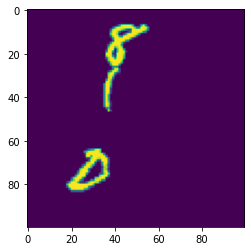

In [24]:
x, y = train_data[0] # Grab an image with its labels
imshow(x.numpy()[0,:])

In [25]:
print(y) #prints out everything
print("Boxes: ", y['boxes']) #prints a tensor showing the pixel locations of the corners for all 3 objects
print("Labels: ", y['labels']) #prints a tensor showing the labels for all 3 objects

{'boxes': tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]]), 'labels': tensor([0, 1, 8])}
Boxes:  tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]])
Labels:  tensor([0, 1, 8])


In [26]:
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters in our backbone
n_filters = 32

In [27]:
backbone = nn.Sequential(
    cnnLayer(C, n_filters),    
    cnnLayer(n_filters, n_filters),
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [28]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((32),), aspect_ratios=((1.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, num_classes=10, image_mean = [0.5], image_std = [0.229], min_size=100, max_size=100, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

In [29]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        optimizer.zero_grad()
        #rcnn wants model(inputs, labels) - not just model(inputs)
        losses = model(inputs, labels)
        # Compute loss, RCNN gives us a list of losses to add up.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        #now proceed like normal
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

In [30]:
model = model.eval()
model = model.to(device)

In [31]:
set_seed(161)

In [32]:
x, y = test_data[0]
print(y) #this is the ideal truth we want to get back

{'boxes': tensor([[31., 65., 59., 93.],
        [10., 36., 38., 64.],
        [64., 24., 92., 52.]]), 'labels': tensor([8, 0, 4])}


In [33]:
with torch.no_grad():
    pred = model([x.to(device)])

In [34]:
print(pred)

[{'boxes': tensor([[31.9313, 65.4917, 59.7824, 93.3052],
        [64.1321, 23.8941, 92.0808, 51.8841],
        [70.3358, 26.2407, 96.2834, 53.7900],
        [64.9917, 24.2980, 92.9516, 52.2016],
        [30.9127, 65.1308, 58.6978, 93.3224]], device='cuda:0'), 'labels': tensor([8, 4, 1, 9, 5], device='cuda:0'), 'scores': tensor([0.9896, 0.9868, 0.1201, 0.0699, 0.0555], device='cuda:0')}]


In [35]:
import matplotlib.patches as patches

In [36]:
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

def showPreds(img, pred):
    """
    img: the image to show the bounding box predictions for
    pred: the Faster R-CNN predictions to show ontop of the image
    """
    fig,ax = plt.subplots(1)
    #plot the image
    ax.imshow(img.cpu().numpy()[0,:])
    #grab the predictions
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    num_preds = labels.shape[0]
    #for each prediction, plot if if it has a high enough score
    for i in range(num_preds):
        plotDetection(ax, boxes[i].cpu().numpy(), label=str(labels[i].item()))
    
    plt.show()

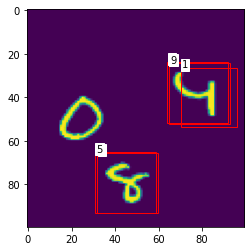

In [37]:
showPreds(x, pred[0])

In [38]:
from torchvision.ops import nms

In [39]:
print(pred[0]['boxes'])

tensor([[31.9313, 65.4917, 59.7824, 93.3052],
        [64.1321, 23.8941, 92.0808, 51.8841],
        [70.3358, 26.2407, 96.2834, 53.7900],
        [64.9917, 24.2980, 92.9516, 52.2016],
        [30.9127, 65.1308, 58.6978, 93.3224]], device='cuda:0')


In [40]:
print(pred[0]['scores'])

tensor([0.9896, 0.9868, 0.1201, 0.0699, 0.0555], device='cuda:0')


In [41]:
print(nms(pred[0]['boxes'], pred[0]['scores'], 0.5))

tensor([0, 1], device='cuda:0')


In [42]:
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots(1)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()

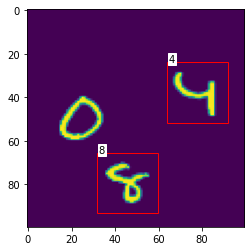

In [43]:
showPreds(x, pred[0])

In [44]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# This RCNN detector is pre setup for a specific set of classes. You can re-use it for your own problems by setting num_classes=10 and pretrained_backbone=True, and then training it with your own data like we did before with MNIST. 

In [45]:
rcnn = rcnn.eval()

In [46]:
# COCO_INSTANCE_CATEGORY_NAMES, these come from the PyTorch documentation. https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
NAME = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [47]:
from PIL import Image
import requests
from io import BytesIO

urls = [
    "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg",
    "https://miro.medium.com/max/5686/1*ZqJFvYiS5GmLajfUfyzFQA.jpeg",
    "https://www.denverpost.com/wp-content/uploads/2018/03/virginia_umbc_001.jpg?w=910"
]

response = requests.get(urls[0])
img = Image.open(BytesIO(response.content))

In [48]:
img = np.asarray(img)/256.0
img = torch.tensor(img, dtype=torch.float32).permute((2,0,1))

with torch.no_grad():
    pred = rcnn([img]) # Pass the image to the model

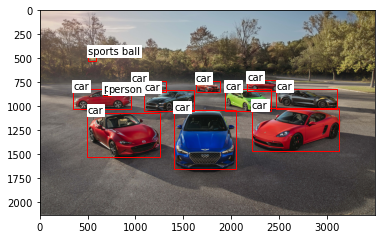

In [49]:
showPreds(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)